 # <font color="#114b98">      <div align="center">   Classez des images à l'aide d'algorithmes de Deep Learning

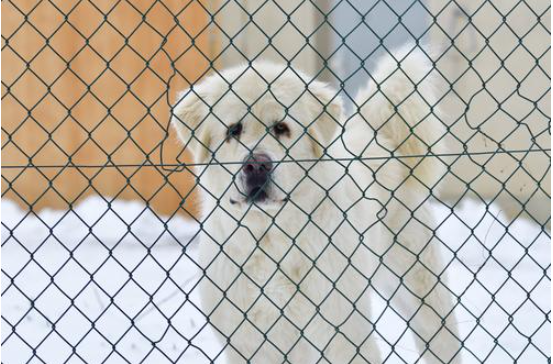

Une association de protection des animaux de notre quartier aimerait avoir une api capable de détecter la race des chiens à partir de son image.
Nous proposons en tant que bénévoles de construire un algorithme de reconnaissance d'image afin d'accélérer leur travail d’indexation.
Les bénévoles de l'association n'ayant pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Nous allons ainsi utiliser la base de données de Stanford Dogs Dataset

L'objectif de ce Notebook est de détailler la mise en place d'un algorithme de détection de la race du chien sur une photo, afin d'accélérer le processus d’indexation dans une base de données.

Les points imposés dans ce projet :

- Pré-processing des  images  (e.g. blanchiment, égalisation,  débruitage...).
- Implémenter de la data augmentation.
- Mise en oeuvre de 2 approches de l'utilisation des CNN :
Réaliser un réseau de neurones CNN from scratch en optimisant les paramètres.
Utiliser le transfert learning et la comparer certains réseaux déjà entrainés.


Le modèle final est une fois choisi et entraîné est enregistré sous le nom : "Saved_model/fine_tune_effecientnetb3.h5". Le  répertoire contient aussi une permutation des races encodés par keras lors de l'entrainement sous le nom "classes.csv".

Tous les Notebooks, le modèl enregistré "fine_tune_effecientnetb3.h5" ainsi que une api  sont versionnés dans un repositoire GitHub disponible à l'adresse: https://github.com/Bounkass/Projet_6_ML_OC

## <font color="#ea1c60">Sommaire</font>  
[1. Chargement et prép-processing des images](#section_1)

[2. Modèle de classification CNN from scratch](#section_2)

[3. Transfert Learning : Modèle CNN pré-entrainé ](#section_3) 

[4. Modèle finale sur toute la base de données](#section_4)


In [1]:
# import  python librairies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import backend as K
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <font id="section_1">1. Chargement et prép-processing des images

Nous allons commencer par une analyse rapide des données de *Stanford Dogs Dataset* concernat la répartition des images races de chiens dans le répertoire images :

#### <font id="section_11"> 1.1 Analyse et visualisation des images

In [5]:
#extract file images.tar
import tarfile
tar = tarfile.open("/content/drive/MyDrive/images.tar")
tar.extractall()
tar.close()

In [6]:
# Count the number of classes (dogs breeds)
path = "/content/Images"
list_of_breed = os.listdir(path)
print("Nombre de race :", (len(list_of_breed)))

Nombre de race : 120


Nous avons 120 races de chiens qui sont présenté dans notre base de données. Cela implique que notre modèle de deep learning va contenir 120 classes à classifer.

In [7]:
#On les stocke dans un dataframe
df = pd.DataFrame(list_of_breed, columns=['Id_name_breed'])
#breed name columns
df['breed_name']=df['Id_name_breed'].apply(lambda x: x.split('-')[1])
# Id of the breed name
df['Id']=df['Id_name_breed'].apply(lambda x: x.split('-')[0])
# number of the pictures for each breed
nb_pic=[]
for name in df.Id_name_breed:
   nb_pic.append(len(os.listdir(path + "/" + name)))

df['nb_pic']=nb_pic

print("Le nombre total des images est:", df["nb_pic"].sum())

Le nombre total des images est: 20580


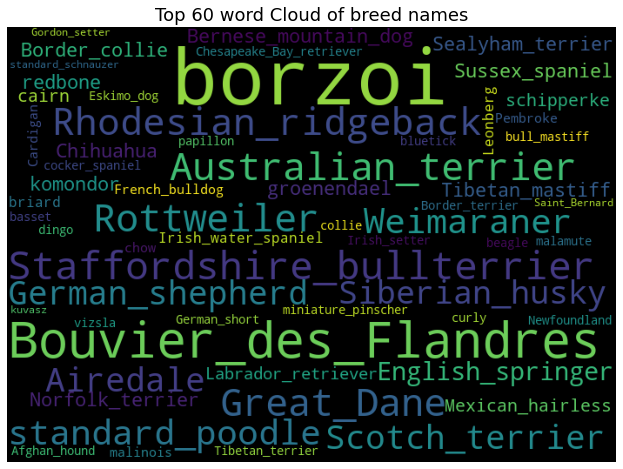

In [8]:
from wordcloud import WordCloud
fig = plt.figure(1, figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=700, height=500,
                      background_color="black",max_words=60, relative_scaling=1,
                      normalize_plurals=False).generate(" ".join(df.breed_name))

ax.imshow(wordcloud)
ax.axis("off")
plt.title("Top 60 word Cloud of breed names", fontsize=18)
plt.show()

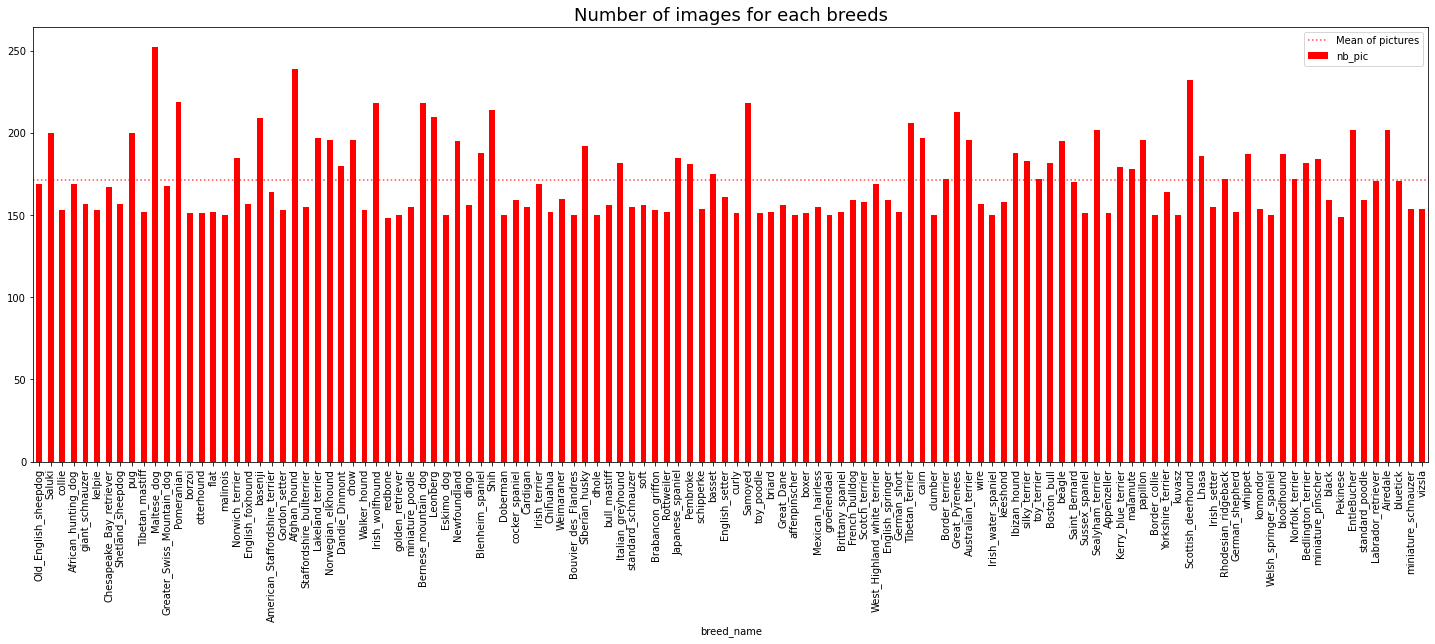

In [8]:

fig, ax = plt.subplots(1, 1, figsize=(25,8))
df.plot(x='breed_name',kind="bar", color='r',legend=False,ax=ax)
ax.axhline(df["nb_pic"].mean(),
           color='r', alpha=.7,
           linestyle=':',
           label="Mean of pictures")
plt.title("Number of images for each breeds",
          color='k', fontsize=18)
plt.legend()
plt.show()

La moyenne des images par race se situe à 171 images par classe et que l'ensemble des images se répartissent entre 150 et 200 images.

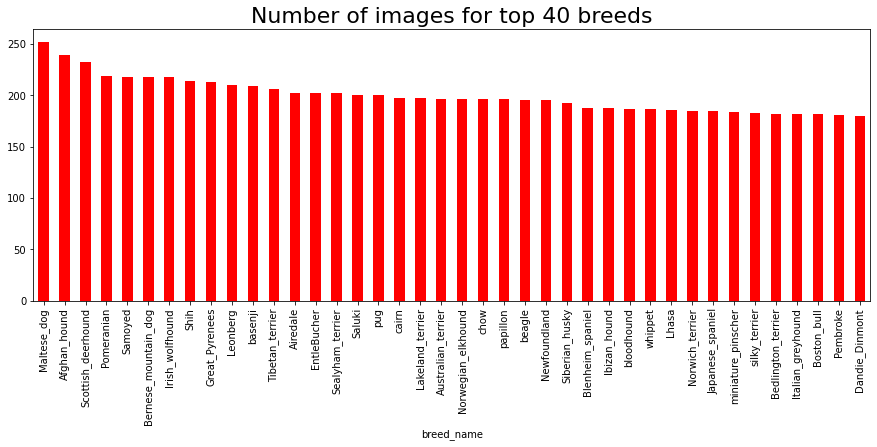

In [9]:
df.sort_values("nb_pic", ascending=False, inplace=True)
top40_bread = df.breed_name[0:40].to_list()
df[0:40].plot(x='breed_name',kind="bar", color='r',legend=False,figsize=(15,5))
plt.title("Number of images for top 40 breeds", color='k', fontsize=22)
plt.show()

Nous allons créer un dataframe qui contient tous les paths des images permettant de lire les images. On alimente aussi ce dataframe par les dimensions des images et les noms des races

In [9]:
#list of directories 
uri_list=[]
for classe in df['Id_name_breed'].values:
    images = os.listdir(path + "/" + classe)
    for i in range(len(images)):
        uri_list.append(path+"/"+ classe +"/"+images[i])
        
#list of images shape        
ds_img=[]
for uri in uri_list:
    ds_img.append(mpimg.imread(uri).shape)

#data frame of results    
ds_img = pd.DataFrame(ds_img, index = uri_list,columns=['heigth','width','color'])
#list of breed which corespoonds to each uri      
y=[]
for j in range(120):
   for k in range(df.nb_pic.values[j]):
      y.append(df.breed_name.values[j])
ds_img['bread_name']=y

In [11]:
ds_img.sample(10)

heigth  width  color  \
/content/Images/n02086910-papillon/n02086910_73...     500    398      3   
/content/Images/n02091244-Ibizan_hound/n0209124...     220    220      3   
/content/Images/n02110063-malamute/n02110063_13...     500    332      3   
/content/Images/n02110958-pug/n02110958_5912.jpg       375    500      3   
/content/Images/n02093991-Irish_terrier/n020939...     500    394      3   
/content/Images/n02090622-borzoi/n02090622_1060...     332    500      3   
/content/Images/n02085936-Maltese_dog/n02085936...     375    500      3   
/content/Images/n02113186-Cardigan/n02113186_99...     374    500      3   
/content/Images/n02096177-cairn/n02096177_9014.jpg     375    500      3   
/content/Images/n02094114-Norfolk_terrier/n0209...     333    500      3   

                                                         bread_name  
/content/Images/n02086910-papillon/n02086910_73...         papillon  
/content/Images/n02091244-Ibizan_hound/n0209124...     Ibizan_hound  
/content/Images/n02110063-malamute/n02110063_13...         malamute  
/content/Images/n02110958-pug/n02110958_5912.jpg                pug  
/content/Images/n02093991-Irish_terrier/n020939...    Irish_terrier  
/content/Images/n02090622-borzoi/n02090622_1060...           borzoi  
/content/Images/n02085936-Maltese_dog/n02085936...      Maltese_dog  
/content/Images/n02113186-Cardigan/n02113186_99...         Cardigan  
/content/Images/n02096177-cairn/n02096177_9014.jpg            cairn  
/content/Images/n02094114-Norfolk_terrier/n0209...  Norfolk_terrier

Regardons la distribution des dimensions des images:

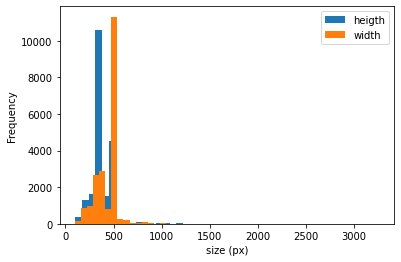

la moyenne (lageur,hauteur) par image:  (385.86, 442.53)


In [12]:
ds_img['heigth'].plot.hist(bins=35, alpha=1)
ds_img['width'].plot.hist(bins=50, alpha=1)
plt.xlabel('size (px)')
plt.legend(['heigth','width'])
plt.show()
print("la moyenne (lageur,hauteur) par image: ", (round(ds_img['heigth'].mean(),2),round(ds_img['width'].mean(),2)))

Les images sont de type "RGB" except une seule image qui a une couche de plus. IL s'agit de la couche alpha, nous allons transformer cette image en "RGB"

In [13]:
ds_img['color'].value_counts()

3    20579
4        1
Name: color, dtype: int64

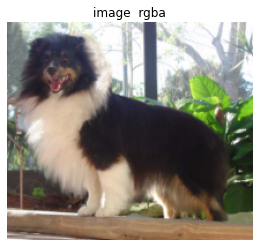

In [10]:
plt.fig = plt.figure(figsize=(10,4))
idx = ds_img[ds_img.color==4].index[0]
img4 = mpimg.imread(idx)
plt.imshow(img4)
plt.title("image  rgba")
plt.axis('off') ;

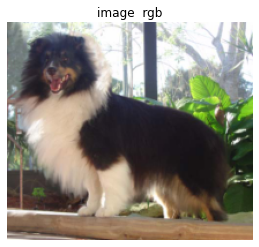

In [11]:
# current directory 
name_img4 = idx.split('/')[-1]
idx=idx.replace(name_img4,'')
os.chdir(idx)
# split image
r_img, g_img, b_img, a_img = cv2.split(img4)
# merge rgb scale
img3 = cv2.merge((r_img, g_img, b_img))
#save rgb image
cv2.imwrite('n02105855_2933.jpg', img3)
plt.imshow(img3)
plt.title("image  rgb")
plt.axis('off') ;

Regardons quelques exemples des images par races disponibles dans notre base d'étude :

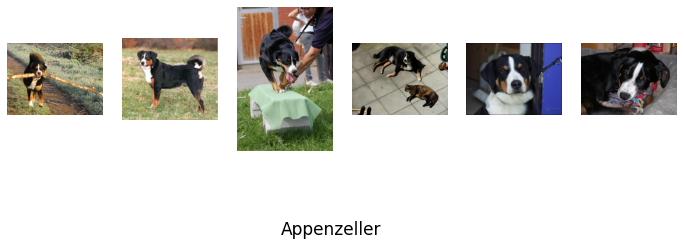

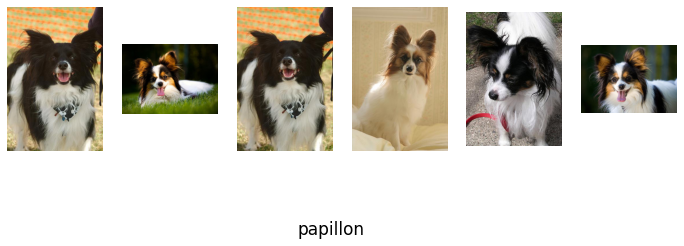

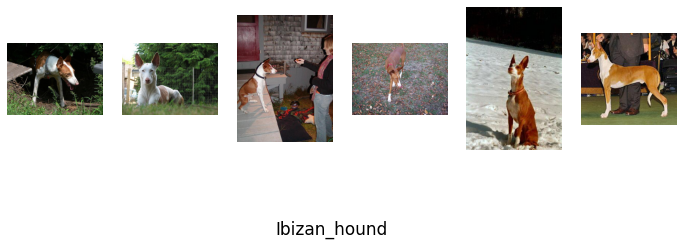

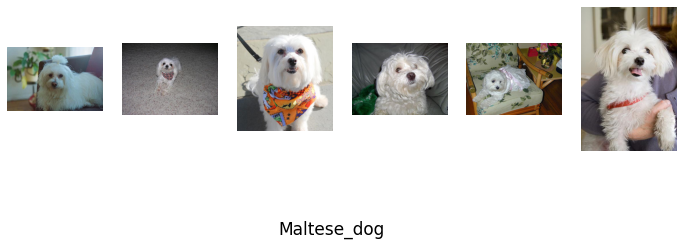

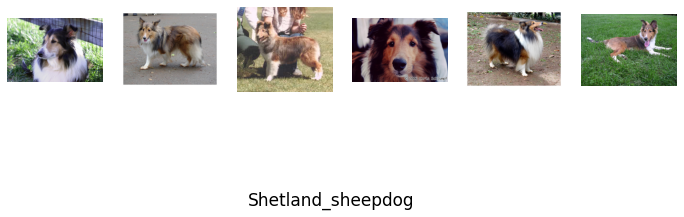

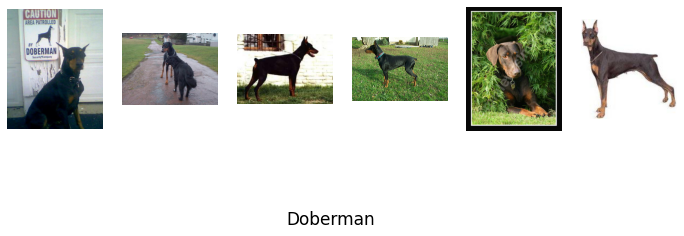

In [16]:
Num = 6
breed_id_sample = np.random.choice(df['Id_name_breed'].values,Num)
for classe in breed_id_sample:
   images = os.listdir(path + "/" + classe)[:Num]
   fig = plt.figure(figsize=(12,4))
   plt.suptitle("{}".format(classe.split("-")[1]), y=.01, color="black", fontsize=17) 
   for i in range(Num):
        img = mpimg.imread(path+"/"+ classe +"/"+images[i])
        plt.subplot(1, Num, i+1)
        plt.imshow(img)
        plt.axis('off') ;    
   plt.show()

Nous remarquons depuis les exemples ci-dessus, que la dimension des images n'est pas uniforme, Sachons que le modèle CNN exige une taille unique pour toutes les données, nous choisissons de redimensionner les images à une dimension unique (300,300) afin qu'elles soient compatibles avec la plus grande résolution exigée par un réseau effecientnetb3 pré-entrainé considéré dans la section du transfert learninig 

Nous allons ainsi effectuer un ensemble de transformation sur notre base des images. Notamment, la redimensinnement, l'égalisation, le débruitage et le blanchiment.

#### <font id="section_12"> 1.2 Transformation des images

##### 1.2.1 Egalisation d'histogramme

Cette méthode de traitement d'images consiste à  améliorer le contraste de l'image avec une  répartition uniforme de l'intensité lumineuse dans tout le spectre de l'image. Nous utilisons ici l'égalisation avec OpenCV.

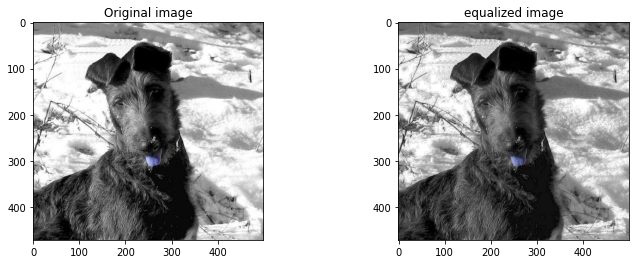

In [17]:

uri = ds_img.index[np.random.randint(1000)]
image = cv2.imread(uri)
# Equalization
r_image, g_image, b_image = cv2.split(image)
r_image_eq = cv2.equalizeHist(r_image)
g_image_eq = cv2.equalizeHist(g_image)
b_image_eq = cv2.equalizeHist(b_image)
image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
cmap_val = None

# Show both images
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(image_eq)
plt.title("equalized image")
plt.show()            
            

##### 1.2.2 Débruitage de l'image

Les images peuvent être bruitées pour différentes causes:

caractéristiques de la caméra, compression des images JPEG ou une mauvaise résolution ...

Il est possible de convoluer l'image avec un filtre pour corriger les pixels. Il en existe de plusieurs types : les filtres linéaires (comme le filtre Gaussien), non linéaires comme le filtre médian par exemple.
L'un des meilleurs filtre est le filtre non-local means. Celui-ci prend une moyenne de tous les pixels  pondérée par la similarité du pixel cible avec les autres. Cela nous évite de trop lisser l'image, contrairement aux filtres classiques, qui prennent la valeur moyenne localement pour lisser l'image.

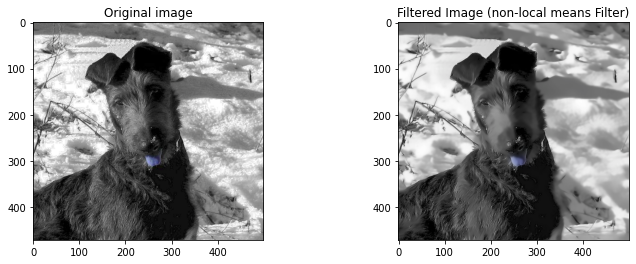

In [18]:
# Apply non-local means filter on test img
img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)
# Show both img
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(image_eq)
plt.title("Original image")
plt.subplot(1, 2, 2)
plt.imshow(img_nlf)
plt.title("Filtered Image (non-local means Filter)")
plt.show()

##### 1.2.3 Whitening d'image

Le whitening “blanchiment” d’une image consiste à décorréler l’image en supprimant  la corrélation spatiale entre les pixels, Le réseau peut converger alors plus rapidement avec le blanchiment.


In [19]:
def zca_whitening(image, eps):
  """function  that compute  the whitening transformation of a color image with ZCA
  --------------------
  param:
  image: image to process
  eps: threshold of whitening <1
  """

  #removing the mean from each pixel
  image_c = image - image.mean(axis=0)
  
  #split image_c into 3 colors 
  r_image, g_image, b_image = cv2.split(image_c)
 
  # calculate the covariance matrix of the zero-centered data
  cov_r = np.cov(r_image,rowvar=False,bias=True)
  cov_g = np.cov(g_image,rowvar=False, bias=True)
  cov_b = np.cov(b_image,rowvar=False, bias=True)
 
  # compute the singular value decomposition (SVD) of covariance matrix
  U_r,S_r,V_r = np.linalg.svd(cov_r)
  U_g,S_g,V_g = np.linalg.svd(cov_g)
  U_b,S_b,V_b = np.linalg.svd(cov_b)
 

  # Whitening transform using ZCA (Zero Component Analysis)
  r_img_zca = U_r.dot(np.diag(1.0/np.sqrt(S_r + eps))).dot(U_r.T).dot(r_image.T).T
  g_img_zca = U_g.dot(np.diag(1.0/np.sqrt(S_g + eps))).dot(U_g.T).dot(g_image.T).T
  b_img_zca = U_b.dot(np.diag(1.0/np.sqrt(S_b + eps))).dot(U_b.T).dot(b_image.T).T
  
  img_zca = cv2.merge((r_img_zca,g_img_zca,b_img_zca))+image.mean(axis=0)/255
  return img_zca

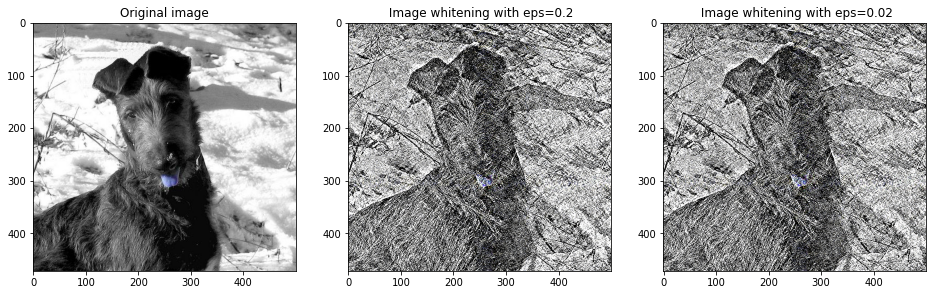

In [20]:
image = cv2.imread(uri)
x_1 = zca_whitening(image,0.2)
x_2 = zca_whitening(image, 0.02)
fig = plt.figure(figsize=(16,5))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(x_1)
plt.title(" Image whitening with eps=0.2")
plt.subplot(1, 3, 3)
plt.imshow(x_2)
plt.title(" Image whitening with eps=0.02")
plt.show()

##### 1.2.4 Augmentation de données


La **Data Augmentation** a pour objectif  de reproduire plus d'images à partir des images préexistantes afin d'essayer d'éviter le risque de sur-entraineemnt d'un modèle de réseau de neurones 

La méthode consiste à appliquer des **transformations géométriques aléatoires** à chaque image. Pour cela, Keras avec la méthode "ImageDataGenerator"  permet de faire de du mirroring, de la rotation, des zoom ... 

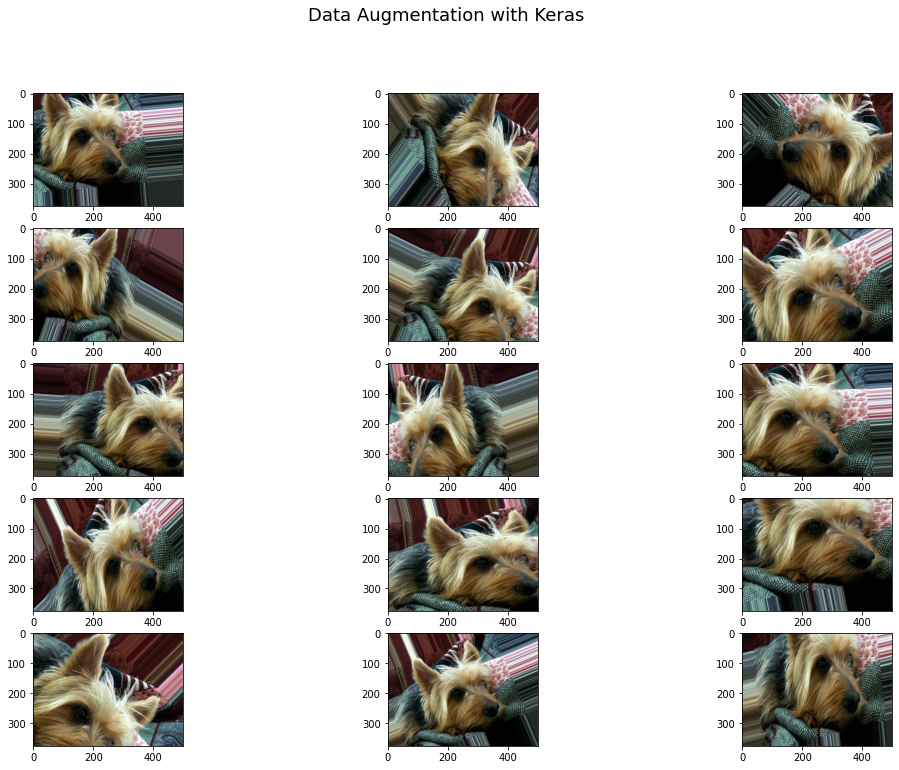

In [21]:
datagen = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        rescale=1./255,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        fill_mode='nearest')

# Convert an imgage to array
x = mpimg.imread(ds_img.index.values[4112])
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(18,12))
for batch in datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(5,3,i+1)
    ax.imshow( tf.keras.preprocessing.image.array_to_img(batch[0]))
    i += 1
    if i % 15 == 0:
        break

plt.suptitle("Data Augmentation with Keras", fontsize=18)
plt.show()

### <font id="section_13"> 1.3. Préparation des données pour le modèle CNN

Nous allons créer une fonction qui regroupe les transformations  de preprocessing précedentes et qui retournera les labels et les images transformées dans un tableau np array y et X.  Nous utilisons la fonction split pour partager nos images en données d'entrainement et de test.

In [17]:
def preprocessing(uri_list,input_shape):
    """Preprocessing of images for convolutional neural network.
    Equalization, Denoising and transformation of the image into Array. 
    ------------------
    param:
    uri_list: 
    list of images directories
    input_shape: 
    (width, heigth) size of the image  for target resizing
    """
    img_list=[]
    for uri in uri_list:
            # Read image
            image = cv2.imread(uri)
            # Resize image
            image = cv2.resize(image, input_shape)
            # Equalization
            r_image, g_image, b_image = cv2.split(image)
            r_image_eq = cv2.equalizeHist(r_image)
            g_image_eq = cv2.equalizeHist(g_image)
            b_image_eq = cv2.equalizeHist(b_image)
            image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
            # Apply non-local means filter 
            img_nlf = cv2.fastNlMeansDenoisingColored(image_eq,None,10,10,7,21)
            
            # Append lists of labels and image
            img_list.append(img_nlf)
            #labels = ds_img.bread_name[0:tot_nb_img]
        
  
    return np.array(img_list)

Nous allons créer et entrainer le modèle CNN avec top 5 races en nombre d'images

In [23]:
import time
nb_breeds = 5
time1 = time.time()
uri_list=ds_img.index.values[0:np.sum(df.nb_pic.values[0:nb_breeds])]
X = preprocessing(uri_list, (300,300))
y = ds_img.bread_name[0:np.sum(df.nb_pic.values[0:nb_breeds])]
# Convert data in numpy array
y = np.array(y)    
#Encode labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
time2 =time.time()-time1
print("-" * 60)
print(" preprocessing time :", round(time2,1))
print("-" * 60)
print("Number of images preprocessed :", X.shape[0])


------------------------------------------------------------
 preprocessing time : 391.2
------------------------------------------------------------
Number of images preprocessed : 1160


In [24]:
X.shape

(1160, 300, 300, 3)

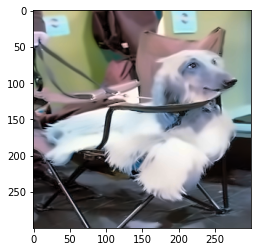

In [25]:
# Show exemple preprocessed image
plt.imshow(X[321])
plt.show()

In [26]:
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

In [27]:
X_train.shape

(928, 300, 300, 3)

In [28]:
X_test.shape

(232, 300, 300, 3)

### <font id="section_2">2. Modèle de classification CNN from scratch

Nous allons créer et entrainer les modèles sur les n premières top races des chiens (suivant le nombre d'images). Nous pourrons ensuite étendre l'algorithme à l'ensemble des races si les résultats sont satisfaisants.

In [29]:
# Data generator on train set with Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#Rescale test set
test_datagen = ImageDataGenerator(rescale=1./255)

Ces générateurs de la data augmentation seront introduits dans les pipeline de la modélisation Keras.

#### <font id="section_21"> 2.1. Construction du modèle CNN

 
Nous allons  difinir le  modèle CNN en imbriquant plusieurs couches :
- **Couches de convolution** : repérer un ensemble de features dans un image
- **Couches de Pooling** : consiste à réduire la taille des images, tout en préservant les features importantes.
- **Couches de correction ReLU** : La couche de correction ReLU remplace toutes les valeurs négatives reçues et  joue le rôle de fonction d'activation.
- **Couches Fully connected** : Ce type de couche reçoit un vecteur en entrée et produit un nouveau vecteur en sortie. Pour cela, elle applique une combinaison linéaire puis éventuellement une fonction d'activation aux valeurs reçues en entrée.
- **DropOut** : La méthode du dropout consiste à « désactiver » des sorties de neurones aléatoirement pour éviter le sur-entraînement.

Nous allons assayer d'optimiser les hyperparamètres du modèle en choisissant ceux qui minimisent l'erreur et maximise la précision

In [30]:
def model_cnn(filt, ker_s, wind, strd, f_act,nb_breed):
   """ 
   """
   K.clear_session()
   model = Sequential()
   # Convolution layer
   model.add(Conv2D(filters=filt, kernel_size=ker_s, input_shape=(300, 300, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
   # Pooling layer
   model.add(MaxPooling2D(pool_size= wind, strides=(strd,strd), padding='same'))
   # Second convolution layer
   model.add(Conv2D(filters=2*filt, kernel_size=ker_s, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
   # Pooling layer
   model.add(MaxPooling2D(pool_size=wind, strides=(strd,strd), padding='same'))
   # Third convolution layer
   model.add(Conv2D(filters=4*filt, kernel_size=ker_s, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
   # Pooling layer
   model.add(MaxPooling2D(pool_size=wind, strides=(strd,strd), padding='same'))
   # Fourth convolution layer
   model.add(Conv2D(filters=8*filt, kernel_size=ker_s, padding='same'))
   model.add(BatchNormalization())
   model.add(Activation(f_act))
   model.add(GlobalAveragePooling2D())
   model.add(Dropout(0.4))
   model.add(Flatten())
   # Fully connected layers
   model.add(Dense(16*filt, activation=f_act))
   model.add(Dense(nb_breed, activation='softmax'))

   return model

La fonction suivante permet de présenter les différentes courbes de l'entrainement du modèle

In [ ]:
def plot_scores_curves(result, Columns, name):
  """
  function which plots scores curves for various values paramater in the list Columns
  #--------------
  param:
  result: dictionary of history results of cnn model
  Columns : list of values parameter
  param: name of the parameter in analysis
  """
  # 
  val_loss = {k:v.history['val_loss'] for k,v in result.items()}
  val_acc = {k:v.history['val_accuracy'] for k,v in result.items()}

  val_loss_curves = pd.DataFrame(val_loss)
  val_loss_curves.columns =Columns
  val_acc_curves = pd.DataFrame(val_acc)
  val_acc_curves.columns =Columns
  sns.set_style("whitegrid")

  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  for col in Columns:
     ax[0].plot(val_loss_curves[col], label=col)
     ax[1].plot(val_acc_curves[col], label=col)
  
  ax[0].set_title("Impact of " + name +  " on the loss")
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[1].set_title("Impact of " + name +  " on the accuracy ")
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  plt.show()

Commençant par tester 4 types de fonctions d'activation

In [ ]:
act_fun = ['relu', 'sigmoid','selu', 'tanh']
result = {}

for f_act in act_fun:
  #set model 
  model = model_cnn(16, 3,2,2, f_act, 5)
  # Compile the CNN Model
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=20);

  #
  result[f_act] = history



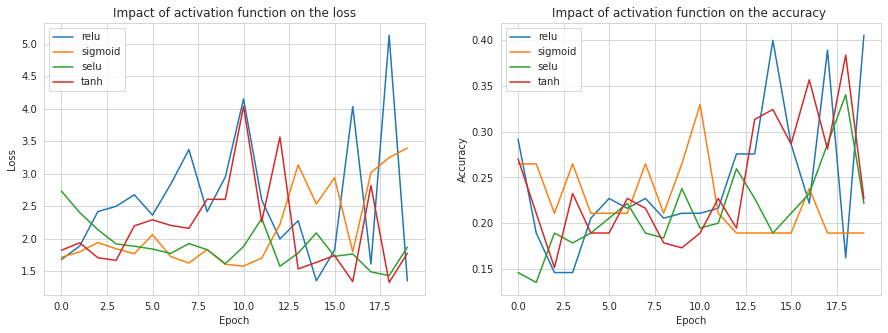

In [ ]:
result = result
Columns = act_fun
name = 'activation function'
plot_scores_curves(result, Columns, name)

En comparant les deux figures de l'erreur et de la précision, on peut conclure que globalement les résultats sont significativement  meilleurs en utilisant pour fonction d'activation "relu". Nous allons ainsi conserver cette fonction dans la suite.

Comparant trois algorithmes d'optimisation

In [ ]:
optimizers = ['adam', 'SGD', 'adamax']
result = {}

for optimizer in optimizers:
  #set  model
  model = model_cnn(16, 3, 2, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=20)
  #concatenate result
  result[optimizer] = history

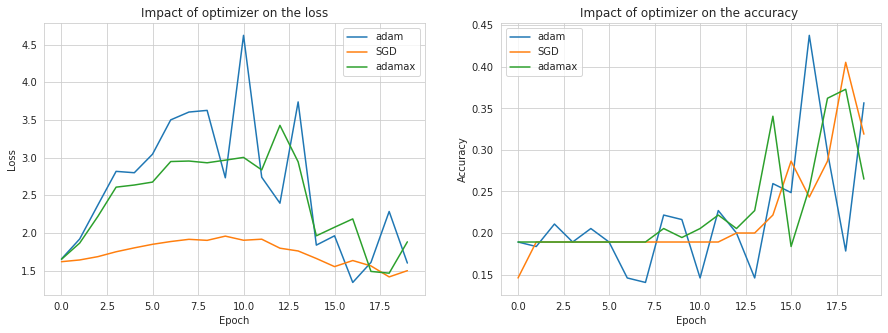

In [ ]:
result = result
Columns = optimizers
name = 'optimizer'
plot_scores_curves(result, Columns, name)

Les résultats sont relativement similaires avec les trois optimiseurs. Nous allons consever dans la suite le modèle  d'optimisation "adam". Regardons le nombre de filtre pour la couche de convolution

In [ ]:
filter = [4, 8, 16, 32]
result = {}

for filt in filter:
  #set  model
  model = model_cnn(filt, 3, 2, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=20)
  #concatenate result
  result[filt] = history

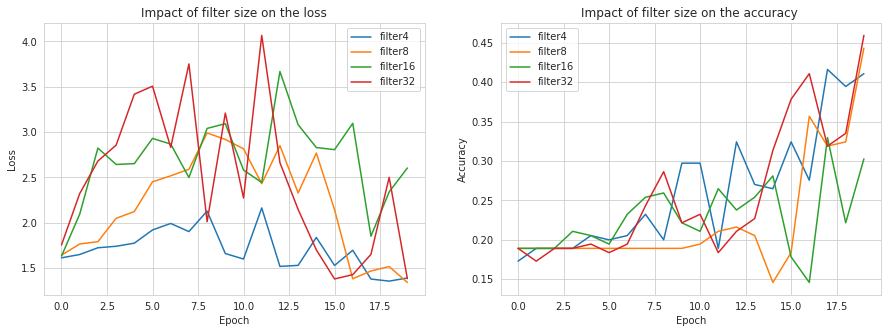

In [ ]:
result = result
Columns = ['filter4','filter8','filter16','filter32']
name = 'filter size'
plot_scores_curves(result, Columns, name)

Nous choisissons dans la suite  k=8 comme nombre du filtre

In [ ]:
kernel = [3, 4, 5]
result = {}

for k in kernel:
  #set  model
  model = model_cnn(8, k, 2, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=20)
  #concatenate result
  result[k] = history

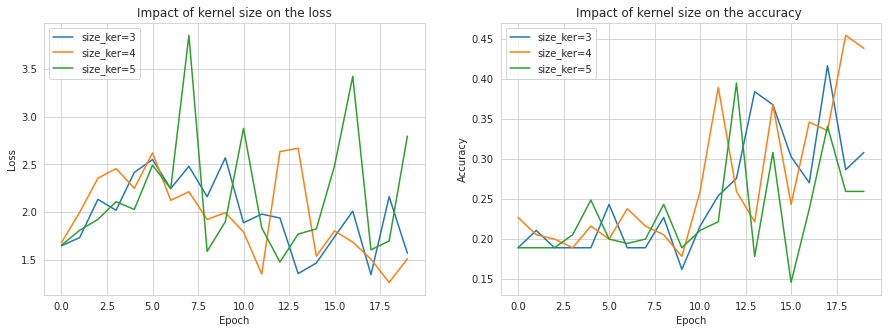

In [ ]:
result = result
Columns = ['size_ker=3','size_ker=4','size_ker=5']
name = 'kernel size'
plot_scores_curves(result, Columns, name)

En comparant les deux figures de l'erreur et de la précision, on peut conclure que globalement les résultats sont significativement meilleurs avec size_ker = 4 comme une taille du noyau.

In [ ]:
Wind = [3, 4, 5]
result = {}

for w in Wind:
  #set  model
  model = model_cnn(8, 4, w, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train) / 32,
                       epochs=20)
  #concatenate result
  result[w] = history

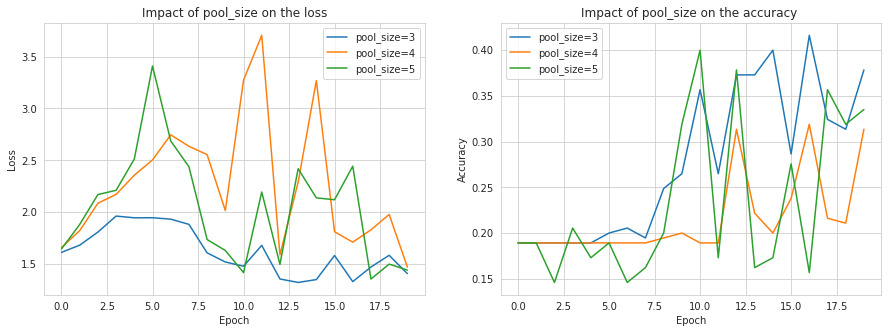

In [ ]:
result = result
Columns = ['pool_size=3','pool_size=4','pool_size=5']
name = 'pool_size'
plot_scores_curves(result, Columns, name)

Les résultas montrent qu'avec 3 comme pas de pooling sont meilleurs. Regardons le nombre d'epochs.

In [ ]:
epochs = [10, 20, 30, 40, 50]
result = {}

for epoch in epochs:
  #set  model
  model = model_cnn(8, 4, 3, 2, "relu", 5)
  # Compile the CNN Model with optimizer algorithm
  model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",
                 metrics="accuracy")
  history = model.fit( train_datagen.flow(
                       X_train, y_train, batch_size=16, subset='training'),
                       validation_data=train_datagen.flow( X_train, y_train,
                       batch_size=16, subset='validation'),
                       steps_per_epoch=len(X_train)/32, epochs=epoch)
  #concatenate result
  result[epoch] = history

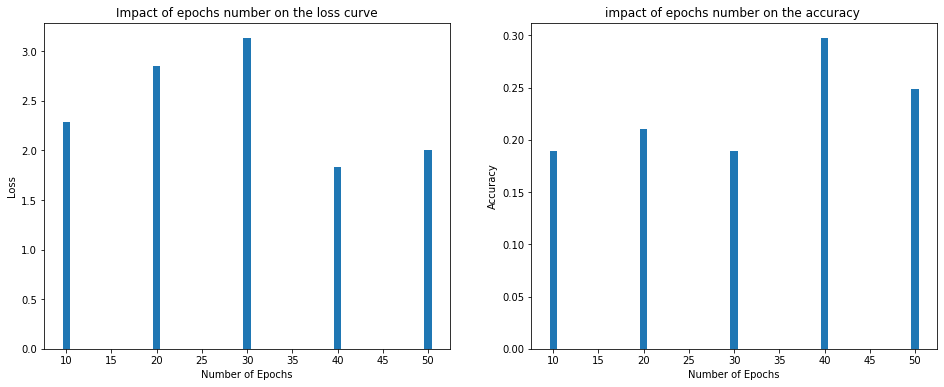

In [ ]:
#Final result extraction
val_loss = {k:v.history['val_loss'][-1] for k,v in result.items()}
val_acc = {k:v.history['val_accuracy'][-1] for k,v in result.items()}
#bar plot 
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].bar(epochs, list(val_loss.values()))
ax[0].set_title("Impact of epochs number on the loss curve")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel('Loss')
ax[1].bar(epochs, list(val_acc.values()))
ax[1].set_title("impact of epochs number on the accuracy ")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel('Accuracy')
plt.show()

En comparant les deux figures, on choisit  40 épochs pour entrainer le modèle CNN from scratch qui imprime le résumé suivant:

In [ ]:
#set  model
model = model_cnn(8, 4, 3, 2, "relu", 5)
# Compile the CNN Model with optimizer algorithm
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics="accuracy")
#model.build(input_shape=(None, 300, 300, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 4)       196       
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 4)      16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 300, 300, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 8)       520       
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 8)      3

#### <font id="section_22"> 2.2. Entrainement et évaluation du modèle CNN

Notre modèle est créé avec des paramètres convenable, nous allons pouvoir l'entrainer et l'évaluer sur 40 époques:

In [ ]:
#set  model
model = model_cnn(4, 4, 3, 2, "relu", 5)
# Compile the CNN Model with optimizer algorithm
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics="accuracy")
model.fit( train_datagen.flow(X_train, y_train, batch_size=16, subset='training'),
                     validation_data=train_datagen.flow( X_train, y_train, batch_size=16, subset='validation'),
                     steps_per_epoch=len(X_train)/32, epochs=40)
# Prediction
y_pred = np.argmax(model.predict(test_datagen.flow(
                    X_test, y_test,batch_size=16,shuffle=False)), axis=1)

Epoch 1/40
29/29 [==============================] - 25s 417ms/step - loss: 1.5978 - accuracy: 0.2659 - val_loss: 1.6123 - val_accuracy: 0.1892
Epoch 2/40
29/29 [==============================] - 13s 464ms/step - loss: 1.5031 - accuracy: 0.2989 - val_loss: 1.6851 - val_accuracy: 0.1892
Epoch 3/40
29/29 [==============================] - 12s 404ms/step - loss: 1.5407 - accuracy: 0.2931 - val_loss: 1.7638 - val_accuracy: 0.1892
Epoch 4/40
29/29 [==============================] - 12s 400ms/step - loss: 1.5820 - accuracy: 0.2593 - val_loss: 1.7911 - val_accuracy: 0.1892
Epoch 5/40
29/29 [==============================] - 11s 397ms/step - loss: 1.5058 - accuracy: 0.2923 - val_loss: 1.8613 - val_accuracy: 0.1892
Epoch 6/40
29/29 [==============================] - 12s 400ms/step - loss: 1.5308 - accuracy: 0.3341 - val_loss: 2.1518 - val_accuracy: 0.1892
Epoch 7/40
29/29 [==============================] - 11s 396ms/step - loss: 1.4613 - accuracy: 0.3538 - val_loss: 1.9568 - val_accuracy: 0.1892

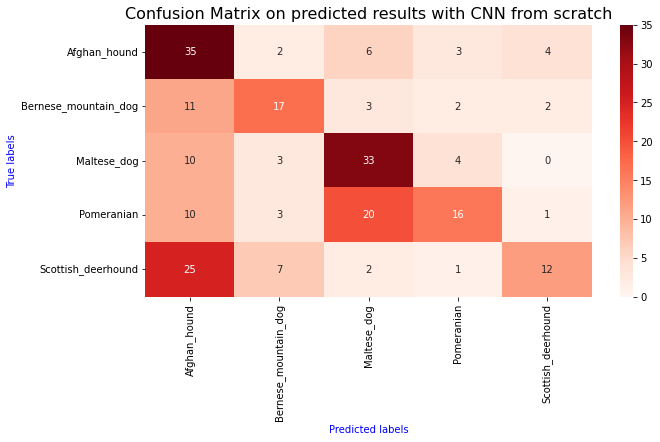

In [ ]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,5))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds')
ax.set_xlabel("Predicted labels", color="b")
ax.set_ylabel("True labels", color="b")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on predicted results with CNN from scratch", fontsize=16)
plt.show()

In [ ]:
print("Precision Score (macro) : {:.3f}".format(precision_score(y_test, y_pred,average='macro',zero_division=1)))
print("Precision Score (micro) : {:.3f}".format(precision_score(y_test, y_pred,average='micro',zero_division=1)))

print("Recall Score (macro) :    {:.3f}".format(recall_score(y_test, y_pred, average='macro')))
print("Recall Score (micro) :    {:.3f}".format( recall_score(y_test, y_pred, average='micro')))

Precision Score (macro) : 0.536
Precision Score (micro) : 0.487
Recall Score (macro) :    0.484
Recall Score (micro) :    0.487


On voit que sur ce modèle CNN from scratch avec 5 races de chien affich des bon résultas avec une précision qui dépasse 50% et une bonne matrice de confusion. 
Nous allons essayer ce modèle avec 20 races.

#### <font id="section_23"> 2.3. Modèle CNN from scratch avec 20 races

Nous allons préparer nos images avec 20top races de chiens afin de retester le score du modèle CNN from scratch avec les mêmes paramètres qui l'a définissent précédement.

In [ ]:
nb_classes = 20
uri_list=ds_img.index.values[0:np.sum(df.nb_pic.values[0:nb_classes])]
# preprocessing images and store them in array X with array of 20 classes in y
X, y = preprocessing(uri_list, (300,300))
# Convert data in numpy array
X = np.array(X)
y = np.array(y)    
#Encode labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

In [ ]:

#set  model with 20 classes
model20 = model_cnn(8, 4, 3, 2, "relu", nb_classes)
# Compile model 
model20.compile(optimizer='adam', loss="sparse_categorical_crossentropy",metrics="accuracy")
# Fit model
history = model20.fit( train_datagen.flow(X_train, y_train, batch_size=32, subset='training'),
                     validation_data=train_datagen.flow( X_train, y_train, batch_size=32, subset='validation'),
                     steps_per_epoch=len(X_train)/64, epochs=40)

# Prediction
y_pred = np.argmax(model20.predict(test_datagen.flow(
                    X_test, y_test,batch_size=32,shuffle=False)), axis=1)

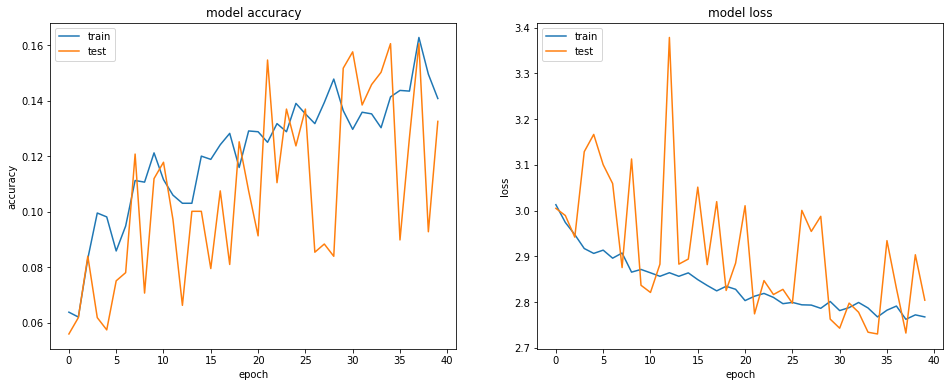

In [ ]:
# summarize history for accuracy
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')
# summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.show()

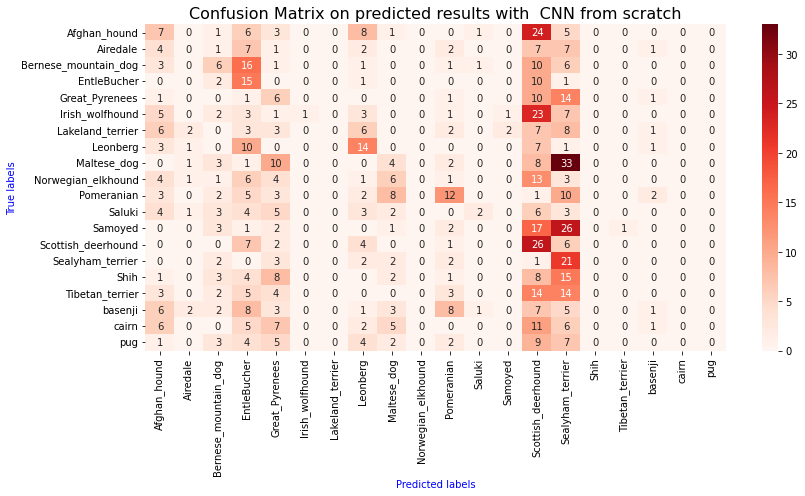

In [ ]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(13,6))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds')
ax.set_xlabel("Predicted labels", color="b")
ax.set_ylabel("True labels", color="b")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on predicted results with  CNN from scratch", fontsize=16)
plt.show()

In [ ]:
print("Precision Score (macro) : {:.3f}".format(precision_score(y_test, y_pred,average='macro',zero_division=1)))
print("Precision Score (micro) : {:.3f}".format(precision_score(y_test, y_pred,average='micro',zero_division=1)))

print("Recall Score (macro) :    {:.3f}".format(recall_score(y_test, y_pred, average='macro')))
print("Recall Score (micro) :    {:.3f}".format( recall_score(y_test, y_pred, average='micro')))

Precision Score (macro) : 0.396
Precision Score (micro) : 0.135
Recall Score (macro) :    0.147
Recall Score (micro) :    0.135


On conclut qu'en augmentant le nombre des races, les scores du modèle CNN chutent considérablement. Ceci est dû au nombre de paramètres  avec à entrainer qui augmente considérablement avec les races.

In [ ]:
model20.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 4)       196       
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 4)      16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 300, 300, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 8)       520       
                                                                 
 batch_normalization_1 (Batc  (None, 150, 150, 8)      3

### <font id="section_3">3. Transfert Learning : Modèle CNN pré-entrainé 

En plus d'accélérer l'entraînement du réseau, le Transfer Learning permet d'éviter le sur-apprentissage lorsque le nombre d'images en entrée est petit. Le réseau de neurones from scratch précedent montre ce risque d'overfitting avec 20 top races.

Dans cette section nous allons comparer le transfert learning avec 4 réseaux de neurones pré-entraîné: **ResNet50, VGG19, EfficientNetB3** et **Xception**

La première fonction qui suit définit le prétraitement convenable pour chaque réseau. La deuxième fonction charge et définit le réseau préentrainé,  remplace les dernières couches fully-connected avec notre problème de classification et une stratégie de fine-tuning, total, extraction des features, ou fine-tuning partiel.    

In [ ]:
def preprocess_func(model_name):
   """
   Preprocesses a tensor or Numpy array encoding  for each model
   -------
   param:
   model_name:
   """ 
   if model_name == 'ResNet50':
     preprocessing_function = tf.keras.applications.resnet50.preprocess_input
   elif model_name == 'VGG19':
     preprocessing_function = tf.keras.applications.vgg19.preprocess_input
   elif model_name == 'EfficientNetB3':
     preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
   else:
     preprocessing_function = tf.keras.applications.xception.preprocess_input

   return preprocessing_function  

In [ ]:
def TF_CNN(model_name, nb_classes, fine_tune):
  """
   Compiles a model integrated with pretrained layers of model 
   given in parameters of this function
   -------
   param:
   model_name: model name
   nb_classes: integer number of breed
   fine_tune:  integer to define the fine tuning strategy 
  """

  # Import the model pretrained without fully-connected layers
  if model_name == 'ResNet50':
    model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
  elif model_name == 'VGG19':
    model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
  elif model_name == 'EfficientNetB3':
    model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300,300,3))
  else:
    model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))

  # Defines how many layers to freeze during training.
  # depending on the size of the fine-tuning parameter.

  if fine_tune > 0:
          for layer in model.layers[:-fine_tune]:
            layer.trainable = False
  else:
        for layer in model.layers:
            layer.trainable = False


  #Define tf model with a new fully-connected layers
  tf_model = Sequential()
  tf_model.add(model)
  tf_model.add(GlobalAveragePooling2D())
  tf_model.add(Dense(512, activation='relu'))
  tf_model.add(Dropout(0.2))
  tf_model.add(Dense(nb_classes, activation='softmax'))

  # Compiles the model for training.
  tf_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
  return tf_model

#### <font id="section_31"> 3.1 Transfert learning avec extraction des features

Nous allons évaluer et comparer le transfert learning avec la stratégie d'extraction des features pour les 4 réseaux et en utilisant 5 race de chiens

In [ ]:
#Dataframe to compare models
model_names = ['VGG19', 'ResNet50', 'EfficientNetB3', 'Xception']
dt_compar = pd.DataFrame([], index= model_names, 
                                      columns=['time_of_fit (s)', 'accuracy_train', 'accuracy_val', 'accuracy_test', 'recall_test' ])

In [ ]:
import time
result = {}
predict ={}
nb_classes = 5
fine_tune = -1

for model_name in model_names:
  K.clear_session()
  start_time = time.time()
  tf_cnn = TF_CNN(model_name, nb_classes, fine_tune)
  # Data generator on train set with Data Augmentation
  train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function= preprocess_func(model_name))
    #rescale testset
  test_datagen = ImageDataGenerator( preprocessing_function=preprocess_func(model_name))
  # fit model
  result_cnn = tf_cnn.fit(train_datagen.flow(X_train, y_train, batch_size=16, subset='training'),
          validation_data=train_datagen.flow(X_train, y_train, batch_size=16, subset='validation'),
          steps_per_epoch=len(X_train) / 32, epochs=30, verbose=2);
  fit_time = round(time.time() - start_time,1)
  # prediction
  y_pred = np.argmax(tf_cnn.predict(test_datagen.flow(X_test, y_test, batch_size=16,shuffle=False), verbose=1), axis=1)
  #compute and store scores
  dt_compar.loc[model_name, 'time_of_fit (s)'] = fit_time
  dt_compar.loc[model_name, 'accuracy_train'] = result_cnn.history['accuracy'][-1]
  dt_compar.loc[model_name, 'accuracy_val'] = result_cnn.history['val_accuracy'][-1]
  dt_compar.loc[model_name, 'accuracy_test'] = accuracy_score(y_test, y_pred)
  dt_compar.loc[model_name, 'recall_test'] = recall_score(y_test, y_pred, average ='macro')

  # store result
  result[model_name] = result_cnn
  predict[model_name] = y_pred

Epoch 1/30
29/29 - 15s - loss: 2.9697 - accuracy: 0.4725 - val_loss: 1.5697 - val_accuracy: 0.5730 - 15s/epoch - 532ms/step
Epoch 2/30
29/29 - 15s - loss: 1.0868 - accuracy: 0.6571 - val_loss: 0.8483 - val_accuracy: 0.7189 - 15s/epoch - 500ms/step
Epoch 3/30
29/29 - 16s - loss: 0.8560 - accuracy: 0.7209 - val_loss: 1.1400 - val_accuracy: 0.6216 - 16s/epoch - 542ms/step
Epoch 4/30
29/29 - 14s - loss: 0.7001 - accuracy: 0.7692 - val_loss: 0.7539 - val_accuracy: 0.7081 - 14s/epoch - 499ms/step
Epoch 5/30
29/29 - 14s - loss: 0.5579 - accuracy: 0.7737 - val_loss: 0.7694 - val_accuracy: 0.7405 - 14s/epoch - 488ms/step
Epoch 6/30
29/29 - 14s - loss: 0.4083 - accuracy: 0.8396 - val_loss: 0.8723 - val_accuracy: 0.7135 - 14s/epoch - 481ms/step
Epoch 7/30
29/29 - 14s - loss: 0.4632 - accuracy: 0.8242 - val_loss: 0.7295 - val_accuracy: 0.7027 - 14s/epoch - 483ms/step
Epoch 8/30
29/29 - 14s - loss: 0.5806 - accuracy: 0.8017 - val_loss: 0.7257 - val_accuracy: 0.7297 - 14s/epoch - 489ms/step
Epoch 9/

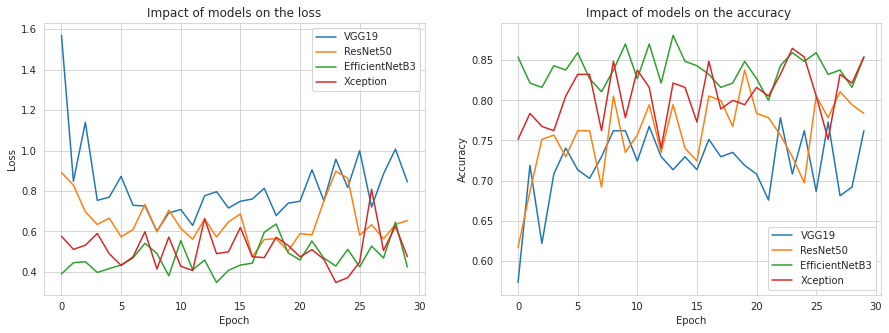

In [ ]:
result = result
Columns = model_names
name = 'models'
plot_scores_curves(result, Columns, name)

In [ ]:
dt_compar

time_of_fit (s) accuracy_train accuracy_val accuracy_test  \
VGG19                    528.0       0.935345     0.762162      0.844828   
ResNet50                 527.9       0.928879     0.783784      0.853448   
EfficientNetB3           507.9       0.971429     0.854054      0.922414   
Xception                 479.5       0.914286     0.854054      0.900862   

               recall_test  
VGG19              0.84265  
ResNet50          0.846967  
EfficientNetB3    0.918334  
Xception          0.892243

Confusion Matrix of VGG19:
--------------------------------------------------


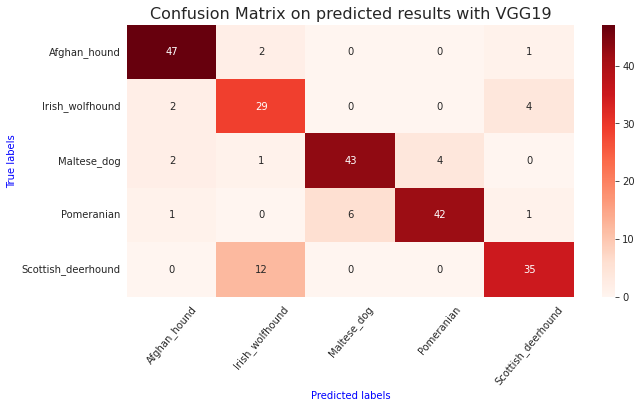

Confusion Matrix of ResNet50:
--------------------------------------------------


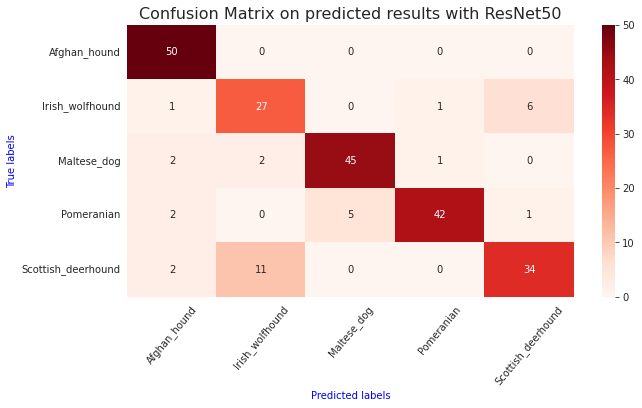

Confusion Matrix of EfficientNetB3:
--------------------------------------------------


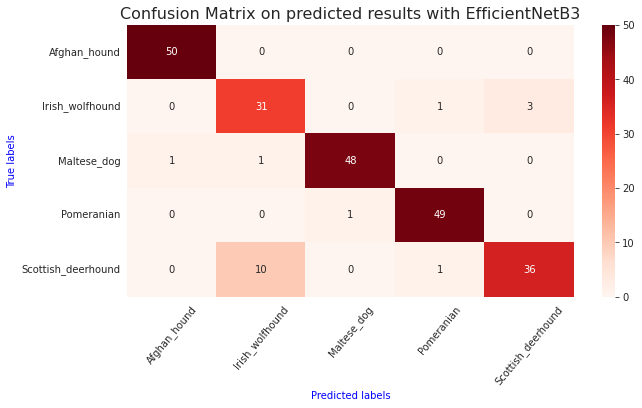

Confusion Matrix of Xception:
--------------------------------------------------


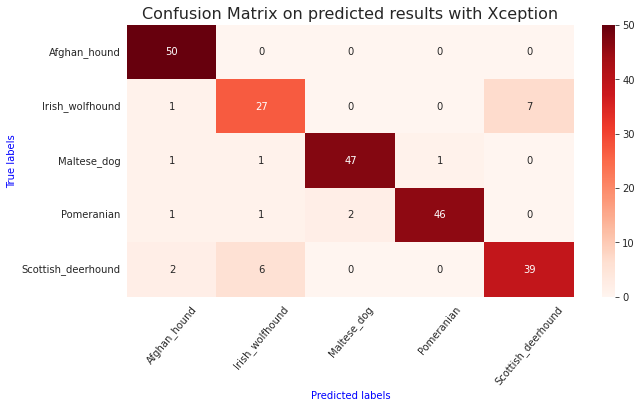

In [ ]:
# Confusion Matrix of models
for model_name in model_names:
   print(f'Confusion Matrix of {model_name}:')
   print("-"*50)

   cf_matrix = confusion_matrix(y_test, predict[model_name])
   fig = plt.figure(figsize=(10,5))
   ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds')
   ax.set_xlabel("Predicted labels", color="b")
   ax.set_ylabel("True labels", color="b")
   ax.xaxis.set_ticklabels(encoder.classes_, rotation=50)
   ax.yaxis.set_ticklabels(encoder.classes_, rotation='horizontal')
   plt.title(f"Confusion Matrix on predicted results with {model_name}", fontsize=16)
   plt.show()

On remarque en comparant les différents scores que  les deux modèles Xception et Effecienetb3 pré-entrainés avec extraction des feature. Nous allons ensuite comparer ces deux modèles avec fine tuning partiel.

#### <font id="section_31"> 3.1 Transfert learning avec partial fine tuning

In [ ]:
#Dataframe to compare models
model_names = ['EfficientNetB3', 'Xception']
dt_ptf = pd.DataFrame([], index= model_names, 
                                      columns=['time_of_fit (s)', 'accuracy_train', 'accuracy_val', 'accuracy_test', 'recall_test' ])
dt_ptf

In [ ]:
import time
result = {}
nb_classes = 5
fine_tune = 6
gc.collect();
for model_name in model_names:
  K.clear_session()
  start_time = time.time()
  tf_cnn = TF_CNN(model_name, nb_classes, fine_tune)
  # Data generator on train set with Data Augmentation
  train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function= preprocess_func(model_name))
    #rescale testset
  test_datagen = ImageDataGenerator( preprocessing_function=preprocess_func(model_name))
  
  result_cnn = tf_cnn.fit(train_datagen.flow( X_train, y_train, batch_size=16, subset='training'),
          validation_data=train_datagen.flow(X_train, y_train, batch_size=16, subset='validation'),
          steps_per_epoch=len(X_train) / 32, epochs=30, verbose=2);
  fit_time = round(time.time() - start_time,1)
  # prediction
  y_pred = np.argmax(tf_cnn.predict(test_datagen.flow(X_test, y_test, batch_size=16,shuffle=False), verbose=1), axis=1)
  #compute and store scores
  dt_ptf.loc[model_name, 'time_of_fit (s)'] = fit_time
  dt_ptf.loc[model_name, 'accuracy_train'] = result_cnn.history['accuracy'][-1]
  dt_ptf.loc[model_name, 'accuracy_val'] = result_cnn.history['val_accuracy'][-1]
  dt_ptf.loc[model_name, 'accuracy_test'] = accuracy_score(y_test, y_pred)
  dt_ptf.loc[model_name, 'recall_test'] = recall_score(y_test, y_pred, average ='macro')

  # store result
  result[model_name] = result_cnn

Epoch 1/30
29/29 - 26s - loss: 0.8054 - accuracy: 0.6789 - val_loss: 0.4478 - val_accuracy: 0.8270 - 26s/epoch - 907ms/step
Epoch 2/30
29/29 - 13s - loss: 0.3594 - accuracy: 0.8685 - val_loss: 0.3503 - val_accuracy: 0.8649 - 13s/epoch - 439ms/step
Epoch 3/30
29/29 - 13s - loss: 0.2873 - accuracy: 0.8879 - val_loss: 0.5041 - val_accuracy: 0.8162 - 13s/epoch - 461ms/step
Epoch 4/30
29/29 - 13s - loss: 0.3426 - accuracy: 0.8725 - val_loss: 0.4820 - val_accuracy: 0.8216 - 13s/epoch - 435ms/step
Epoch 5/30
29/29 - 14s - loss: 0.2444 - accuracy: 0.9055 - val_loss: 0.4850 - val_accuracy: 0.8000 - 14s/epoch - 485ms/step
Epoch 6/30
29/29 - 14s - loss: 0.2510 - accuracy: 0.9011 - val_loss: 0.4449 - val_accuracy: 0.8162 - 14s/epoch - 490ms/step
Epoch 7/30
29/29 - 13s - loss: 0.2387 - accuracy: 0.9095 - val_loss: 0.4897 - val_accuracy: 0.8216 - 13s/epoch - 444ms/step
Epoch 8/30
29/29 - 13s - loss: 0.1576 - accuracy: 0.9310 - val_loss: 0.4808 - val_accuracy: 0.8270 - 13s/epoch - 442ms/step
Epoch 9/

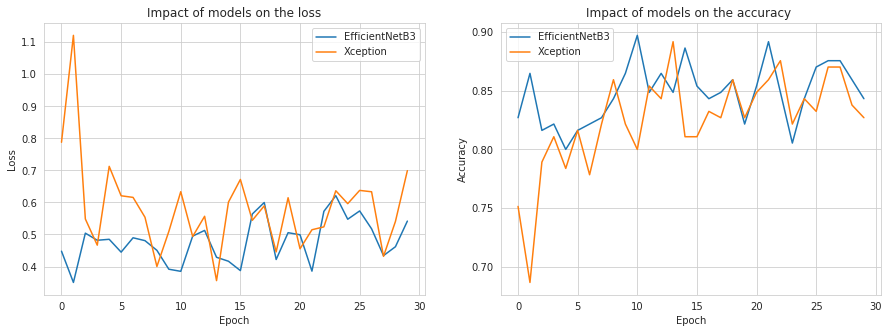

In [ ]:
result = result
Columns = model_names
name = 'models'
plot_scores_curves(result, Columns, name)

In [ ]:
dt_ptf

time_of_fit (s) accuracy_train accuracy_val accuracy_test  \
EfficientNetB3           536.9       0.971429     0.843243      0.913793   
Xception                 511.7       0.980603     0.827027      0.918103   

               recall_test  
EfficientNetB3     0.91059  
Xception          0.918018

En comparant les deux tableaux des scores la stratégie d'extraction des features est meilleur avec le modèle EfficientNetB3 et moins bon pour le modèl Xception avec un coût de plus du temps d'entrainement. Nous comparons dans la suite la première stratégie avec 20 races

#### <font id="section_31"> 3.1 Transfert learning avec extraction des features avec 20 races

In [ ]:
nb_classes = 20
uri_list=ds_img.index.values[0:np.sum(df.nb_pic.values[0:nb_classes])]
# preprocessing images and store them in array X with array of 20 classes in y
X, y = preprocessing(uri_list, (300,300))
# Convert data in numpy array
X = np.array(X)
y = np.array(y)    
#Encode labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
#Séparation jeux entraînement/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

In [ ]:
#Dataframe to compare models
model_names = ['EfficientNetB3', 'Xception']
dt_compar20 = pd.DataFrame([], index= model_names, 
                                      columns=['time_of_fit (s)', 'accuracy_train', 'accuracy_val', 'accuracy_test', 'recall_test' ])

In [ ]:
import time
result = {}
predict ={}
nb_classes = 20
fine_tune = -1

for model_name in model_names:
  gc.collect();
  K.clear_session()
  start_time = time.time()
  tf_cnn = TF_CNN(model_name, nb_classes, fine_tune)
  # Data generator on train set with Data Augmentation
  train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function= preprocess_func(model_name))
    #rescale testset
  test_datagen = ImageDataGenerator( preprocessing_function=preprocess_func(model_name))
  
  result_cnn = tf_cnn.fit(train_datagen.flow( X_train, y_train, batch_size=16, subset='training'),
          validation_data=train_datagen.flow(X_train, y_train, batch_size=16, subset='validation'),
          steps_per_epoch=len(X_train) / 32, epochs=30, verbose=2);
  fit_time = round(time.time() - start_time,1)
  # prediction
  y_pred = np.argmax(tf_cnn.predict(test_datagen.flow(X_test, y_test, batch_size=16,shuffle=False), verbose=1), axis=1)
  #compute and store scores
  dt_compar20.loc[model_name, 'time_of_fit (s)'] = fit_time
  dt_compar20.loc[model_name, 'accuracy_train'] = result_cnn.history['accuracy'][-1]
  dt_compar20.loc[model_name, 'accuracy_val'] = result_cnn.history['val_accuracy'][-1]
  dt_compar20.loc[model_name, 'accuracy_test'] = accuracy_score(y_test, y_pred)
  dt_compar20.loc[model_name, 'recall_test'] = recall_score(y_test, y_pred, average ='macro')

  # store result
  result[model_name] = result_cnn
  predict[model_name] = y_pred

Epoch 1/30
84/84 - 42s - loss: 1.5853 - accuracy: 0.5353 - val_loss: 1.0086 - val_accuracy: 0.6722 - 42s/epoch - 497ms/step
Epoch 2/30
84/84 - 38s - loss: 0.9106 - accuracy: 0.7184 - val_loss: 0.9123 - val_accuracy: 0.7259 - 38s/epoch - 456ms/step
Epoch 3/30
84/84 - 37s - loss: 0.7382 - accuracy: 0.7640 - val_loss: 0.8757 - val_accuracy: 0.7333 - 37s/epoch - 443ms/step
Epoch 4/30
84/84 - 37s - loss: 0.7257 - accuracy: 0.7676 - val_loss: 0.8902 - val_accuracy: 0.7241 - 37s/epoch - 444ms/step
Epoch 5/30
84/84 - 37s - loss: 0.6594 - accuracy: 0.8022 - val_loss: 0.8552 - val_accuracy: 0.7407 - 37s/epoch - 442ms/step
Epoch 6/30
84/84 - 37s - loss: 0.6432 - accuracy: 0.7875 - val_loss: 0.8801 - val_accuracy: 0.7148 - 37s/epoch - 443ms/step
Epoch 7/30
84/84 - 37s - loss: 0.6256 - accuracy: 0.7912 - val_loss: 0.8468 - val_accuracy: 0.7185 - 37s/epoch - 444ms/step
Epoch 8/30
84/84 - 37s - loss: 0.5663 - accuracy: 0.8154 - val_loss: 0.8186 - val_accuracy: 0.7556 - 37s/epoch - 440ms/step
Epoch 9/

In [ ]:
dt_compar20

time_of_fit (s) accuracy_train accuracy_val accuracy_test  \
EfficientNetB3          1324.8       0.949265     0.783333      0.881657   
Xception                1184.1       0.881618      0.72963      0.844675   

               recall_test  
EfficientNetB3    0.878953  
Xception          0.844691

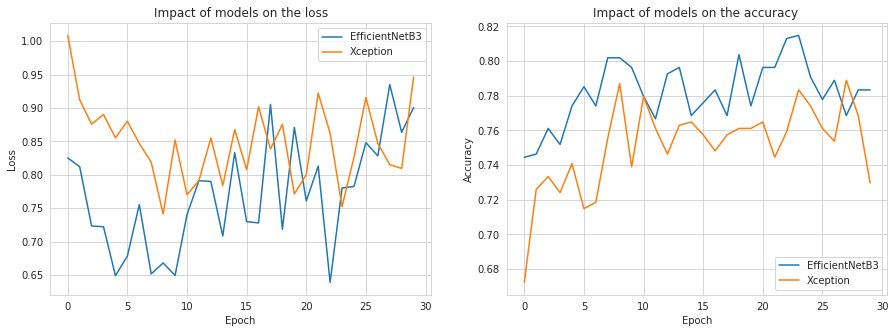

In [ ]:
result = result
Columns = ['EfficientNetB3', 'Xception']
name = 'models'
plot_scores_curves(result, Columns, name)

Confusion Matrix of EfficientNetB3:
--------------------------------------------------


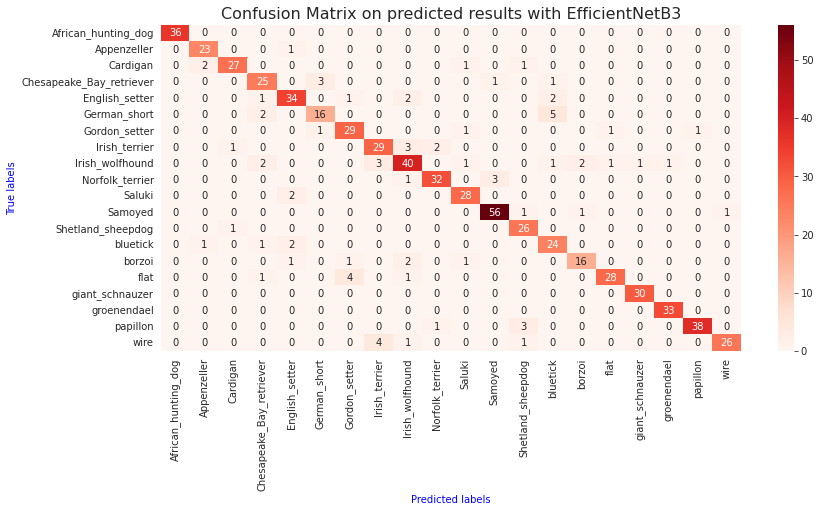

Confusion Matrix of Xception:
--------------------------------------------------


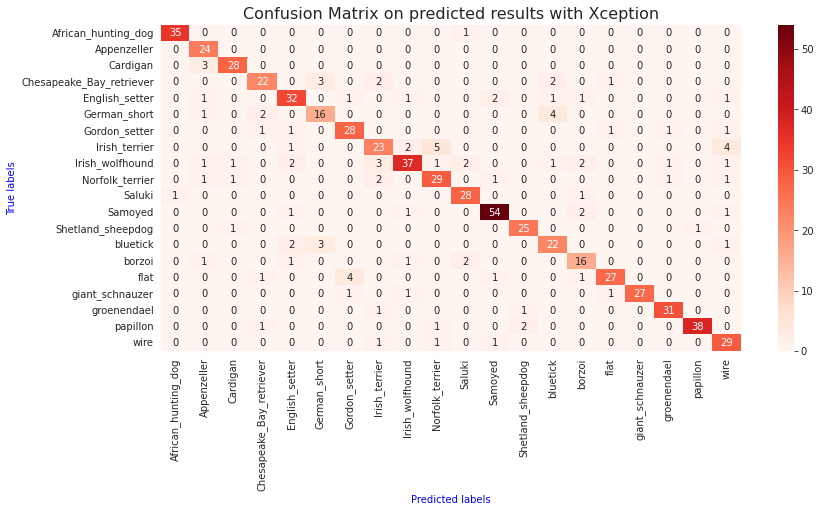

In [ ]:
# Confusion Matrix of models
for model_name in ['EfficientNetB3', 'Xception']:
   print(f'Confusion Matrix of {model_name}:')
   print("-"*50)

   cf_matrix = confusion_matrix(y_test, predict[model_name])
   fig = plt.figure(figsize=(13,6))
   ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds')
   ax.set_xlabel("Predicted labels", color="b")
   ax.set_ylabel("True labels", color="b")
   ax.xaxis.set_ticklabels(encoder.classes_, rotation=90)
   ax.yaxis.set_ticklabels(encoder.classes_, rotation=0)
   plt.title(f"Confusion Matrix on predicted results with {model_name}", fontsize=16)
   plt.show()

In [ ]:
# Classification report
from sklearn.metrics import classification_report
# Inverse transform
test_classes = encoder.inverse_transform(y_test)
print(classification_report(y_test, predict["EfficientNetB3"],
                      target_names=sorted(set(test_classes))))

                          precision    recall  f1-score   support

     African_hunting_dog       1.00      1.00      1.00        36
             Appenzeller       0.88      0.96      0.92        24
                Cardigan       0.93      0.87      0.90        31
Chesapeake_Bay_retriever       0.78      0.83      0.81        30
          English_setter       0.85      0.85      0.85        40
            German_short       0.80      0.70      0.74        23
           Gordon_setter       0.83      0.88      0.85        33
           Irish_terrier       0.81      0.83      0.82        35
         Irish_wolfhound       0.80      0.77      0.78        52
         Norfolk_terrier       0.91      0.89      0.90        36
                  Saluki       0.88      0.93      0.90        30
                 Samoyed       0.93      0.95      0.94        59
       Shetland_sheepdog       0.81      0.96      0.88        27
                bluetick       0.73      0.86      0.79        28
         

In [ ]:
# Classification report
from sklearn.metrics import classification_report
# Inverse transform
test_classes = encoder.inverse_transform(y_test)
print(classification_report(y_test, predict["Xception"], target_names=sorted(set(test_classes))))

                          precision    recall  f1-score   support

     African_hunting_dog       0.97      0.97      0.97        36
             Appenzeller       0.75      1.00      0.86        24
                Cardigan       0.90      0.90      0.90        31
Chesapeake_Bay_retriever       0.81      0.73      0.77        30
          English_setter       0.80      0.80      0.80        40
            German_short       0.73      0.70      0.71        23
           Gordon_setter       0.82      0.85      0.84        33
           Irish_terrier       0.72      0.66      0.69        35
         Irish_wolfhound       0.86      0.71      0.78        52
         Norfolk_terrier       0.78      0.81      0.79        36
                  Saluki       0.85      0.93      0.89        30
                 Samoyed       0.92      0.92      0.92        59
       Shetland_sheepdog       0.89      0.93      0.91        27
                bluetick       0.73      0.79      0.76        28
         

La matrice de confusion et le rapport de classification nous indiquent que les résultats sont assez satisfaisants aussi avec 20 races pour les deux modèles
avec une supériorité pour le modèle EffecientNet. Nous choisissons ce modèle  avec une stratégie d'extraction des features comme modèle final pour entrainer notre base de données complète. 


### <font id="section_4">4. Modèle finale sur toute la base de données

Nous allons préparer et faire une partition de notre base d'images, une collection d'entrainement, une de validation et une autre de test. Nous pour cela utilisons la libraire split-folders. Ensuite utiliser la fonction de keras, flow_from_directory() pour charger l'image directement à partir d'un dossier contenant les images.

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
input_folder = "/content/Images"
splitfolders.ratio(input_folder, output="/content/Images2",seed = 42, ratio=(0.75, 0.15,0.1), group_prefix=None)

Copying files: 20580 files [00:05, 3699.25 files/s]


In [ ]:
path = "/content/Images2/"
train_data_dir = path + "train"
validation_data_dir = path + "val"
test_data_dir = path + "test"
epochs = 20
batch_size = 32
fine_tune = -1
nb_classes = 120 
img_width = 300
img_height = 300
model_name = "EfficientNetB3"

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function = preprocess_func(model_name))
    #rescale testset
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_func(model_name))

Nous allons préparer les images test et les classes afin qu'elle soient compatible pour faire une prédictions avec le modèle entrainé

In [ ]:
#prepare test dataset for prediction
X_test =[]
test_class = []
path_test = "/content/Images2/test"
breed_id = os.listdir(path_test)
for classe in breed_id:
    images = os.listdir(path_test + "/" + classe)
    for i in range(len(images)):
        # read image for each path from datatest directory
        image = cv2.imread(path_test+"/"+ classe +"/"+images[i])
        # resize image
        image = cv2.resize(image, (img_width,img_height))
        X_test.append(image)
        # store the corresponding breed of each image
        test_class.append(classe)

## Convert  to np array
X_test = np.array(X_test)
y_test = np.array(test_class) 
#Encode labels
encoder = LabelEncoder()
encoder.fit(y_test)
y_test = encoder.transform(y_test) 

Nous allons entrainer le modèle EfficientNetB3 avec toutes les races.

In [ ]:
Tf_effecientnetb3 = tf_cnn = TF_CNN("EfficientNetB3", nb_classes , fine_tune)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="sparse")
  
validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="sparse")
  
history_effnet = Tf_effecientnetb3.fit( train_generator, epochs=10, validation_data=validation_generator)

43950080/43941136 [==============================] - 0s 0us/step
Found 15394 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.
Epoch 1/10
482/482 [==============================] - 416s 817ms/step - loss: 1.0154 - accuracy: 0.7331 - val_loss: 0.5546 - val_accuracy: 0.8314
Epoch 2/10
482/482 [==============================] - 390s 809ms/step - loss: 0.5613 - accuracy: 0.8250 - val_loss: 0.5322 - val_accuracy: 0.8374
Epoch 3/10
482/482 [==============================] - 390s 810ms/step - loss: 0.4735 - accuracy: 0.8509 - val_loss: 0.5423 - val_accuracy: 0.8417
Epoch 4/10
482/482 [==============================] - 404s 838ms/step - loss: 0.4238 - accuracy: 0.8614 - val_loss: 0.5369 - val_accuracy: 0.8486
Epoch 5/10
482/482 [==============================] - 404s 838ms/step - loss: 0.3800 - accuracy: 0.8748 - val_loss: 0.5492 - val_accuracy: 0.8370
Epoch 6/10
482/482 [==============================] - 397s 824ms/step - loss: 0.3647 - accuracy: 0.8795 - val_loss: 

In [ ]:
cnn_tf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               61560     
                                                                 
Total params: 11,632,039
Trainable params: 848,504
Non-trainable params: 10,783,535
______________________________________

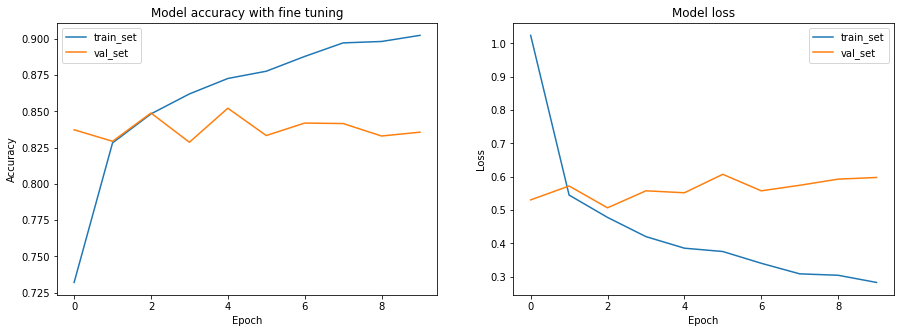

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# summarize history for accuracy
ax[0].plot(history_effnet.history['accuracy'])
ax[0].plot(history_effnet.history['val_accuracy'])
ax[0].set_title('Model accuracy with fine tuning')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train_set','val_set'])

# summarize history for loss
ax[1].plot(history_effnet.history['loss'])
ax[1].plot(history_effnet.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['train_set','val_set'])

plt.show()

Les résultas montrent que le modèle EfficientNetB3 sur toutes les races offre un bon score avec un léger sur-entraineemnt. Evaluant le modèle.

In [ ]:
# Prediction
y_pred = np.argmax(cnn_tf.predict(test_datagen.flow(X_test, y_test, batch_size=16,shuffle=False), verbose=1), axis=1)

136/136 [==============================] - 19s 114ms/step


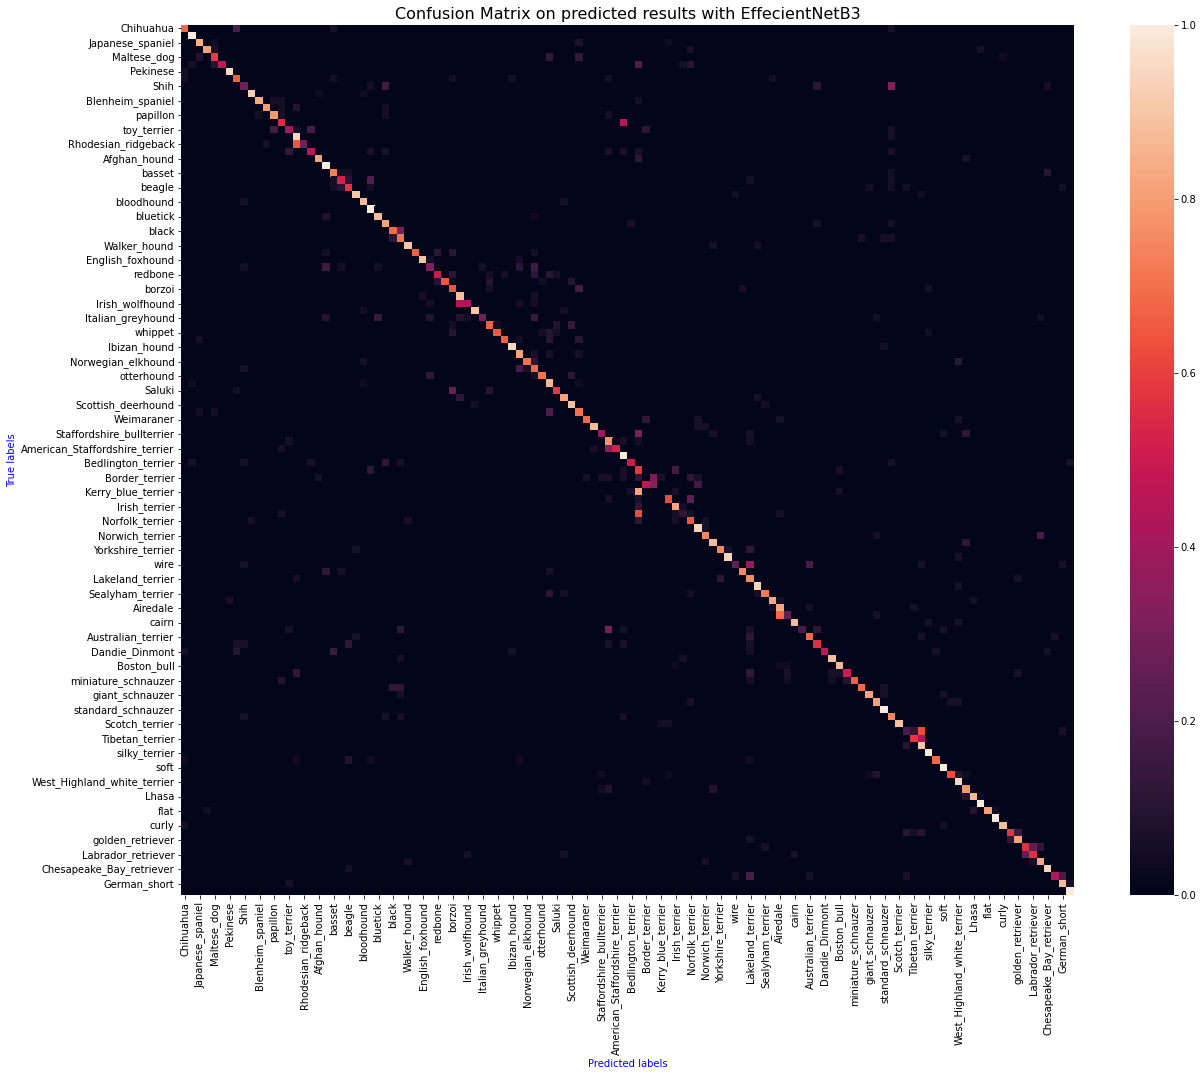

In [ ]:
breeds=[]
for classe in encoder.classes_:
   breeds.append(classe.split('-')[1])

cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
fig = plt.figure(figsize=(20,16))
ax = sns.heatmap(cf_matrix, annot=None)
ax.set_xlabel("Predicted labels", color="b")
ax.set_ylabel("True labels", color="b")
ax.xaxis.set_ticklabels(breeds, rotation=90)
ax.yaxis.set_ticklabels(breeds, rotation=0)
plt.title("Confusion Matrix on predicted results with EffecientNetB3", fontsize=16)
plt.show()

In [ ]:
print("Precision Score (macro) : {:.3f}".format(precision_score(y_test, y_pred,average='macro',zero_division=1)))
print("Precision Score (micro) : {:.3f}".format(precision_score(y_test, y_pred,average='micro',zero_division=1)))

print("Recall Score (macro) :    {:.3f}".format(recall_score(y_test, y_pred, average='macro')))
print("Recall Score (micro) :    {:.3f}".format( recall_score(y_test, y_pred, average='micro')))

Precision Score (macro) : 0.745
Precision Score (micro) : 0.725
Recall Score (macro) :    0.719
Recall Score (micro) :    0.725


La diagonale de la matrice de confusion  contient des coefficients  bien supérieurs à 0.5 (la majorité), on peut en déduire que la plupart des races sont assez bien prédites etque les mauvaises prédictions sont en très petit nombre de races (hors la diagonale) un ou deux coefficients  supérieurs à 0.5  où la couleur est nettement différente de la couleur noire qui désigne la valeur 0. Autrement dit, la confusion potentielle se fait en priorité avec une ou deux races

In [ ]:
for n, i in enumerate(cf_matrix.diagonal().argsort()[:10]):
    if cf_matrix.diagonal()[i] < 0.5:
        print(f'\nLa race la moins bien prédite n°{n+1 : >2} est\n\t{np.sort(breeds)[i]} (<P>={cf_matrix.diagonal()[i]:>4.2f}),  souvent confondu avec :')
        for j in cf_matrix[i].argsort()[-1:-4:-1] :
            if j!=i :
                print(f'\t\t{np.sort(breeds)[j]} (P={cf_matrix[i][j]:>4.2f})')


La race la moins bien prédite n° 1 est
	Siberian_husky (<P>=0.00),  souvent confondu avec :
		Sealyham_terrier (P=0.81)
		cocker_spaniel (P=0.06)
		Scottish_deerhound (P=0.06)

La race la moins bien prédite n° 2 est
	Shetland_sheepdog (<P>=0.00),  souvent confondu avec :
		Shih (P=0.31)
		Sealyham_terrier (P=0.12)
		Tibetan_terrier (P=0.12)

La race la moins bien prédite n° 3 est
	Tibetan_mastiff (<P>=0.12),  souvent confondu avec :
		Sealyham_terrier (P=0.62)
		Sussex_spaniel (P=0.06)

La race la moins bien prédite n° 4 est
	keeshond (<P>=0.19),  souvent confondu avec :
		komondor (P=0.62)
		kelpie (P=0.12)

La race la moins bien prédite n° 5 est
	briard (<P>=0.19),  souvent confondu avec :
		Saluki (P=0.31)
		Great_Dane (P=0.12)

La race la moins bien prédite n° 6 est
	borzoi (<P>=0.25),  souvent confondu avec :
		bluetick (P=0.69)
		flat (P=0.06)

La race la moins bien prédite n° 7 est
	affenpinscher (<P>=0.25),  souvent confondu avec :
		basset (P=0.38)
		bull_mastiff (P=0.19)

La

Avant de visualiser quelques comparaisons de ces prédictions avec leurs labels, nous allons enregistrer notre modèle avec la permutation des classes encodés par le modèle dans un répertoire "/content/drive/MyDrive/Saved_model".

In [ ]:
# Save  Tf_effecientnetb3 model
Tf_effecientnetb3.save('/content/drive/MyDrive/Saved_model/fine_tune_effecientnetb3.h5')

print("fine_tune_effecientnetb3 model")

fine_tune_effecientnetb3 model


In [ ]:
breedset=[]
for classe in encoder.classes_:
    breedset.append(classe.split('-')[1])
dc = pd.DataFrame(breedset,columns=['breed_name'])
dc.to_csv(r'/content/drive/MyDrive/Saved_model/classes.csv', index=False)

visualisation de qualques prédictions:

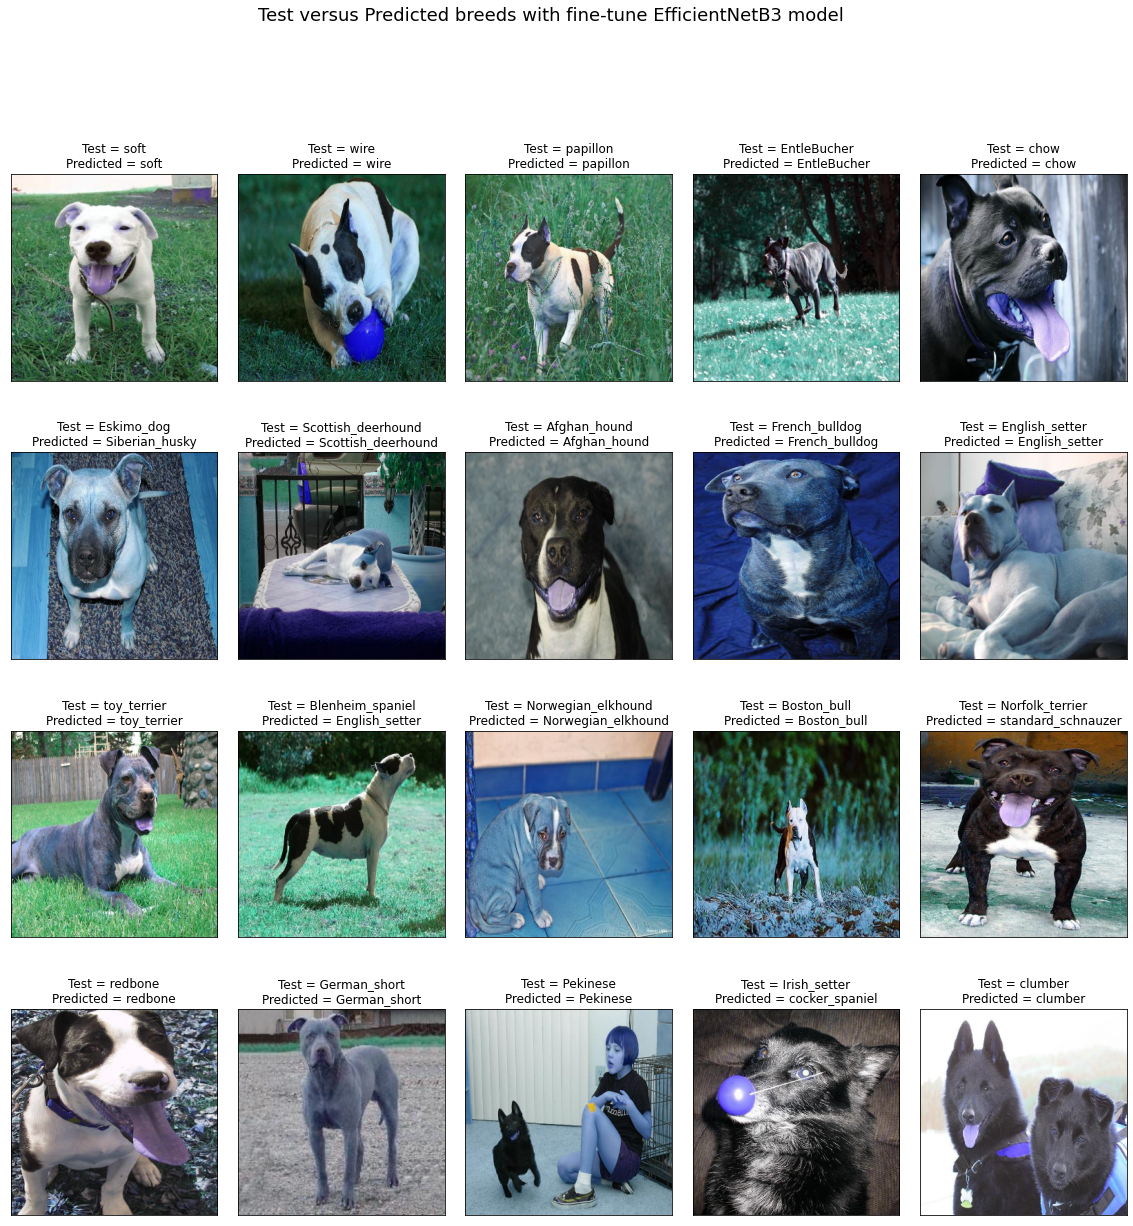

In [ ]:
# Inverse transform of encoding
cl_pred = encoder.inverse_transform(y_pred)
cl_test = encoder.inverse_transform(y_test)
for j in range(len(cl_pred)):
  cl_pred[j]=cl_pred[j].split('-')[1]
  cl_test[j]=cl_test[j].split('-')[1]
  
fig = plt.figure(1, figsize=(20,20))
plt.suptitle("Test versus Predicted breeds with fine-tune EfficientNetB3 model", fontsize=18)

n = 0

for i in range(20):
    n+=1
    m = int(np.random.randint(0, X_test.shape[0], 1))
    plt.subplot(4,5,n)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow((X_test[i]))
    plt.title('Test = {}\nPredicted = {}'.format(cl_test[m] , cl_pred[m]))
    plt.xticks([]) , plt.yticks([])
plt.show()